# Federated Learning with Tensorflow

## Testing neural network

In [1]:
import tensorflow as tf


In [2]:
mnist= tf.keras.datasets.mnist

In [4]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test= x_train/255.0, x_test/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

2022-01-22 15:10:32.033762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [11]:


model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2957 - accuracy: 0.9142
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1421 - accuracy: 0.9576
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1082 - accuracy: 0.9680
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0896 - accuracy: 0.9721
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.0813 - accuracy: 0.9751


[0.08132339268922806, 0.9750999808311462]

## Smart + Dataset 

### Preprocessing

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

In [3]:
path="/Users/daniel.bustillo/Documents/thesis"

In [4]:
os.chdir(path)

In [5]:
#Reading all years from House A
#home_a_1= pd.read_csv("Dataset/HomeA/2014/HomeA-meter2_2014.csv",infer_datetime_format=True, index_col=0, parse_dates=True)
#home_a_2= pd.read_csv("Dataset/HomeA/2014/HomeA-meter3_2014.csv",infer_datetime_format=True, index_col=0, parse_dates=True)

home_a_1_15= pd.read_csv("Dataset/HomeA/2015/HomeA-meter2_2015.csv",infer_datetime_format=True, index_col=0, parse_dates=True)
home_a_2_15= pd.read_csv("Dataset/HomeA/2015/HomeA-meter3_2015.csv",infer_datetime_format=True, index_col=0, parse_dates=True)

home_a_1_16= pd.read_csv("Dataset/HomeA/2016/HomeA-meter2_2016.csv",infer_datetime_format=True, index_col=0, parse_dates=True)
home_a_2_16= pd.read_csv("Dataset/HomeA/2016/HomeA-meter3_2016.csv",infer_datetime_format=True, index_col=0, parse_dates=True)


In [ ]:
#Reading all years from House B

# home_b_1 = pd.read_csv("Dataset/HomeB/2014/HomeB-meter1_2014.csv", infer_datetime_format=True, index_col=0, parse_dates=True)
# home_b_2 = pd.read_csv("Dataset/HomeB/2014/HomeB-meter2_2014.csv", infer_datetime_format=True, index_col=0, parse_dates=True)


In [ ]:
#Reading all years from House C
# home_c_1 = pd.read_csv("Dataset/HomeC/2014/HomeC-meter1_2014.csv", infer_datetime_format=True, index_col=0, parse_dates=True)
# home_c_2 = pd.read_csv("Dataset/HomeC/2014/HomeC-meter2_2014.csv", infer_datetime_format=True, index_col=0, parse_dates=True)


In [6]:
home_a_2_15= home_a_2_15.resample("30T").mean()
home_a_1_16=home_a_1_16.resample("30T").mean()
home_a_2_16 = home_a_2_16.resample("30T").mean()

In [7]:
#home_a_2 =home_a_2.drop("use [kW]", axis=1)
#home_a= home_a_1.merge(right= home_a_2, how="outer",left_index= True, right_index= True)

home_a_2_15 =home_a_2_15.drop("use [kW]", axis=1)
home_a_15= home_a_1_15.merge(right= home_a_2_15, how="outer",left_index= True, right_index= True)

home_a_2_16 =home_a_2_16.drop("use [kW]", axis=1)
home_a_16= home_a_1_16.merge(right= home_a_2_16, how="outer",left_index= True, right_index= True)


In [8]:
# dfs=[home_a, home_a_15, home_a_16]
dfs=[home_a_15, home_a_16]

home_a= pd.concat(dfs)

In [6]:
# home_b_2= home_b_2.drop('use [kW]', axis=1)

# home_b= home_b_1.merge(right=home_b_2, how='outer', left_index=True, right_index=True)

In [7]:
# home_c_2= home_c_2.drop('use [kW]', axis=1)

# home_c= home_c_1.merge(right=home_c_2, how='outer', left_index=True, right_index=True)

In [9]:
#sum all of the electricity consumption
def sum_power(df, label="total"):
    df[label] = df.sum(axis=1)
    return df

In [24]:
#home_a['total'].plot(figsize=(25,5),logy=False, lw=1)

def plot_electricity(df, label="total", figsize=(25,10)):
    df[label].plot(figsize=figsize, lw=1)


<AxesSubplot:xlabel='Date & Time'>

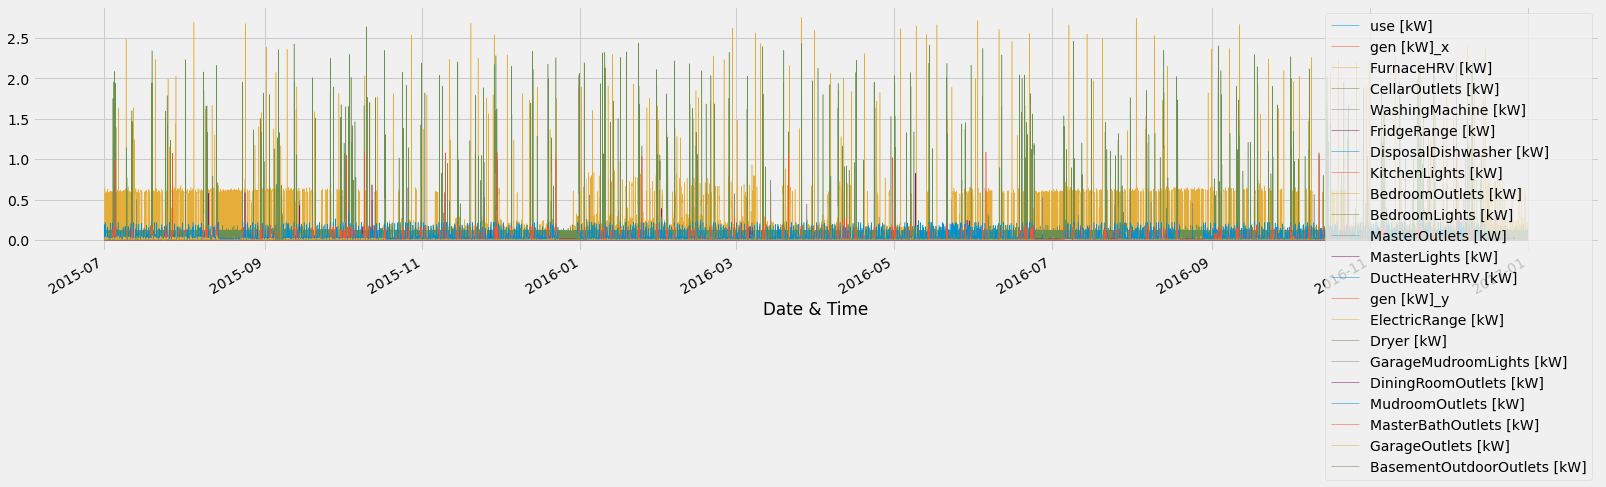

In [13]:
home_a.loc[home_a.index>"2015-07-01"].plot(figsize=(25,5), lw=0.5)

In [18]:
home_a = home_a.loc[home_a.index>"2015-07-01"].copy()

In [19]:
cols_outliers = ['MasterOutlets [kW]','MasterLights [kW]','KitchenLights [kW]', 'BedroomOutlets [kW]','BedroomLights [kW]','DuctHeaterHRV [kW]','ElectricRange [kW]','Dryer [kW]','GarageMudroomLights [kW]',
'DiningRoomOutlets [kW]','MudroomOutlets [kW]','MasterBathOutlets [kW]','GarageOutlets [kW]','BasementOutdoorOutlets [kW]']

### Some EDA 

In [20]:
def rm_outliers(df,cols):
    for i in cols:
        df[i] = np.where(df[i]>4,df[i].median(),df[i])
    return df.describe()


In [21]:
rm_outliers(home_a, cols_outliers)

,use [kW],gen [kW]_x,FurnaceHRV [kW],CellarOutlets [kW],WashingMachine [kW],FridgeRange [kW],DisposalDishwasher [kW],KitchenLights [kW],BedroomOutlets [kW],BedroomLights [kW],...,DuctHeaterHRV [kW],gen [kW]_y,ElectricRange [kW],Dryer [kW],GarageMudroomLights [kW],DiningRoomOutlets [kW],MudroomOutlets [kW],MasterBathOutlets [kW],GarageOutlets [kW],BasementOutdoorOutlets [kW]
count,26399.0,26399.0,26399.000000,26399.000000,2.639900e+04,2.639900e+04,26399.000000,26399.000000,26399.000000,26399.000000,...,26399.000000,25625.0,25625.000000,25625.000000,25625.000000,25625.000000,25625.000000,25625.000000,25625.000000,25625.000000
mean,0.0,0.0,0.158699,0.080120,4.914432e-04,1.340545e-03,0.000135,0.000051,0.008721,0.005913,...,0.003626,0.0,0.021898,0.045901,0.009652,0.002095,0.014118,0.010787,0.006705,0.006255
std,0.0,0.0,0.203181,0.036959,7.119371e-04,7.521273e-03,0.000134,0.000073,0.005016,0.005456,...,0.008781,0.0,0.168479,0.234988,0.013107,0.011892,0.037400,0.044727,0.003200,0.025607
min,0.0,0.0,0.003162,0.000317,5.560000e-07,5.560000e-07,0.000000,0.000000,0.000183,0.000117,...,0.000006,0.0,0.000067,0.000014,0.000067,0.000003,0.000005,0.000083,0.000067,0.000000
25%,0.0,0.0,0.010063,0.049604,3.305550e-05,9.244440e-04,0.000033,0.000009,0.004098,0.004606,...,0.000030,0.0,0.003816,0.003411,0.003744,0.001757,0.002926,0.004814,0.005921,0.000603
50%,0.0,0.0,0.086205,0.085248,1.088890e-04,1.013889e-03,0.000076,0.000022,0.007965,0.004656,...,0.000047,0.0,0.003881,0.003771,0.003880,0.001802,0.002950,0.004839,0.006016,0.004389
75%,0.0,0.0,0.160827,0.114262,6.650000e-04,1.048333e-03,0.000212,0.000067,0.011069,0.004705,...,0.000137,0.0,0.003948,0.003829,0.004722,0.001854,0.002999,0.004865,0.006087,0.008035
max,0.0,0.0,0.929004,0.223113,7.663889e-03,6.453717e-01,0.001198,0.001560,0.153472,0.083535,...,0.051692,0.0,2.750854,2.635057,0.121070,0.868588,0.370500,1.098972,0.126183,0.701991


In [27]:
# print(home_a['KitchenLights [kW]'].quantile(0.5))
# print(home_a['KitchenLights [kW]'].quantile(0.95))
# print(home_a['KitchenLights [kW]'].median())

# home_a['KitchenLights [kW]'] = np.where(home_a['KitchenLights [kW]']>home_a['KitchenLights [kW]'].quantile(0.95),home_a['KitchenLights [kW]'].median(),home_a['KitchenLights [kW]'])
# home_a.describe()

7.5e-05
0.2487190557
7.5e-05


,use [kW],gen [kW]_x,FurnaceHRV [kW],CellarOutlets [kW],WashingMachine [kW],FridgeRange [kW],DisposalDishwasher [kW],KitchenLights [kW],BedroomOutlets [kW],BedroomLights [kW],...,DuctHeaterHRV [kW],gen [kW]_y,ElectricRange [kW],Dryer [kW],GarageMudroomLights [kW],DiningRoomOutlets [kW],MudroomOutlets [kW],MasterBathOutlets [kW],GarageOutlets [kW],BasementOutdoorOutlets [kW]
count,52610.0,52610.0,52610.000000,52610.000000,52610.000000,52610.000000,52610.000000,52610.000000,52610.000000,52610.000000,...,52610.000000,51836.0,51836.000000,51836.000000,51836.000000,51836.000000,51836.000000,51836.000000,51836.000000,51836.000000
mean,0.0,0.0,0.171077,0.070056,0.003703,0.024884,0.008870,0.007946,0.026919,0.043538,...,0.193163,0.0,0.074350,0.047180,0.031673,0.039593,0.012217,0.013699,0.005868,0.008299
std,0.0,0.0,0.205706,0.039665,0.018354,0.047380,0.061520,0.034345,0.444707,7.892213,...,30.439323,0.0,9.795457,3.581652,4.183426,6.190688,0.973998,1.336612,0.406882,0.962444
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.018897,0.037305,0.000056,0.000923,0.000049,0.000014,0.006782,0.004626,...,0.000039,0.0,0.002872,0.003385,0.003716,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.087271,0.071004,0.000495,0.001042,0.000182,0.000075,0.011124,0.004699,...,0.020038,0.0,0.003777,0.003808,0.004337,0.000151,0.002877,0.004657,0.004454,0.000559
75%,0.0,0.0,0.200432,0.108267,0.005508,0.027254,0.004944,0.002935,0.016099,0.004896,...,0.034254,0.0,0.003911,0.005506,0.012758,0.001803,0.002951,0.004841,0.006018,0.004387
max,0.0,0.0,0.929004,0.458419,1.074639,0.992466,0.889513,0.248717,100.787772,1810.228775,...,6981.831507,0.0,1999.719154,701.322889,948.435236,1012.706751,219.545362,252.917249,85.304971,213.680824


In [22]:
sum_power(home_a)

,use [kW],gen [kW]_x,FurnaceHRV [kW],CellarOutlets [kW],WashingMachine [kW],FridgeRange [kW],DisposalDishwasher [kW],KitchenLights [kW],BedroomOutlets [kW],BedroomLights [kW],...,gen [kW]_y,ElectricRange [kW],Dryer [kW],GarageMudroomLights [kW],DiningRoomOutlets [kW],MudroomOutlets [kW],MasterBathOutlets [kW],GarageOutlets [kW],BasementOutdoorOutlets [kW],total
Date & Time,,,,,,,,,,,,,,,,,,,,,
2015-07-01 00:30:00,0.0,0.0,0.211772,0.018335,0.000523,0.000881,0.000328,0.000137,0.015814,0.004690,...,0.0,0.003862,0.003347,0.003966,0.001532,0.002816,0.004792,0.005921,0.000604,0.331396
2015-07-01 01:00:00,0.0,0.0,0.009855,0.108641,0.000025,0.000987,0.000089,0.000061,0.016096,0.004674,...,0.0,0.003807,0.003414,0.003762,0.001781,0.007515,0.004843,0.005993,0.000603,0.226204
2015-07-01 01:30:00,0.0,0.0,0.009825,0.080918,0.000020,0.000988,0.000079,0.000054,0.016083,0.004666,...,0.0,0.003801,0.003419,0.003733,0.001800,0.002909,0.004860,0.006007,0.000597,0.191217
2015-07-01 02:00:00,0.0,0.0,0.009701,0.046086,0.000014,0.000969,0.000099,0.000064,0.015916,0.004657,...,0.0,0.003787,0.003427,0.003734,0.001744,0.002890,0.004853,0.005954,0.000597,0.158663
2015-07-01 02:30:00,0.0,0.0,0.009638,0.114888,0.000027,0.000974,0.000073,0.000052,0.015855,0.004643,...,0.0,0.003756,0.003434,0.003683,0.001757,0.002902,0.004847,0.005934,0.000589,0.223958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 21:30:00,0.0,0.0,0.140308,0.111428,0.000668,0.000987,0.000163,0.000017,0.007810,0.004730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285912
2016-12-31 22:00:00,0.0,0.0,0.102705,0.019827,0.000421,0.000985,0.000156,0.000016,0.007757,0.004719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156306
2016-12-31 22:30:00,0.0,0.0,0.102992,0.115550,0.000207,0.001022,0.000054,0.000007,0.007622,0.004661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.251503


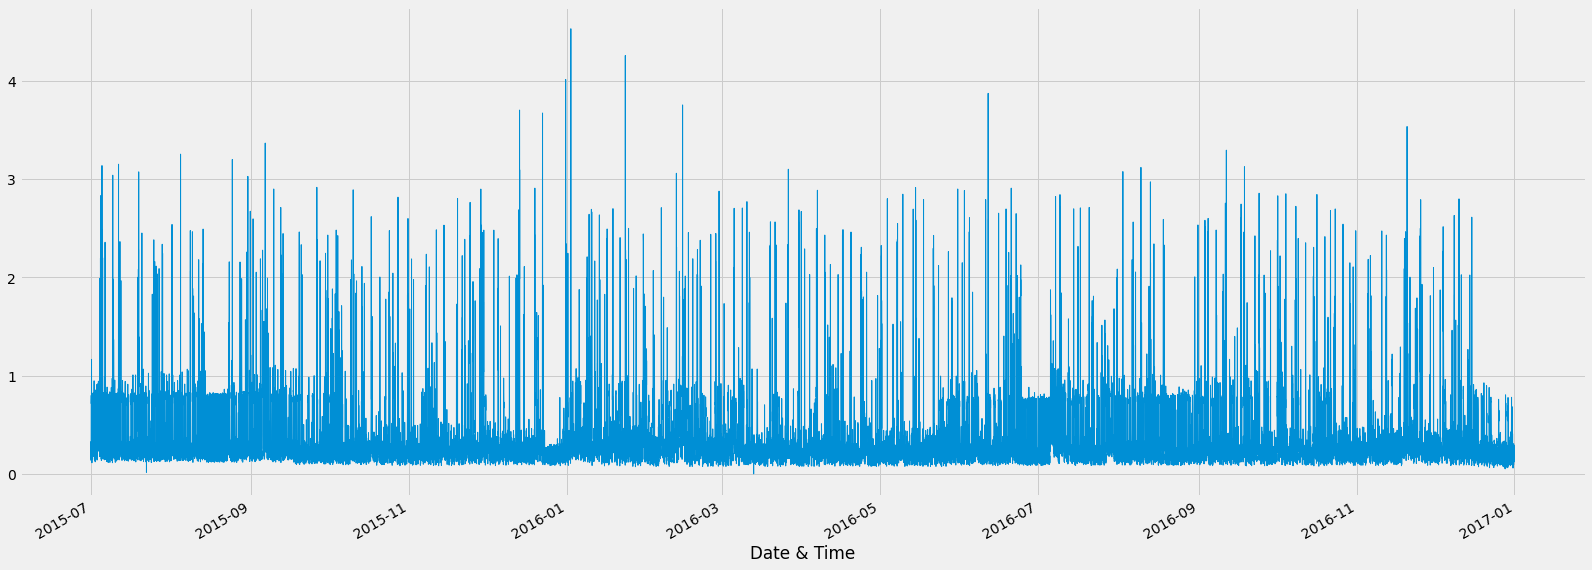

In [25]:
plot_electricity(home_a)

### Simple ARIMA model

In [26]:
# simple ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [27]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(home_a['total'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.366496
p-value: 0.000000


In [38]:
# Original Series
# fig, axes = plt.subplots(3, 2)
# axes[0, 0].plot(home_a['total'], lw=0.5); axes[0, 0].set_title('Original Series')
# plot_acf(home_a['total'], ax=axes[0, 1],lw=0.5)

# # 1st Differencing
# axes[1, 0].plot(home_a['total'].diff(),lw=0.5); axes[1, 0].set_title('1st Order Differencing')
# plot_acf(home_a['total'].diff().dropna(), ax=axes[1, 1],lw=0.5)

# # 2nd Differencing
# axes[2, 0].plot(home_a['total'].diff().diff(),lw=0.5); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(home_a['total'].diff().diff().dropna(), ax=axes[2, 1],lw=0.5)

# plt.show()

In [43]:
#Fitting the model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = np.sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
#warnings.filterwarnings("ignore")
evaluate_models(home_a['total'], p_values, d_values, q_values)

/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [35]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)
    
    # X = df[['hour','dayofweek','quarter','month','year',
    #        'dayofyear','dayofmonth']]
    # if label:
    #     y = df[label]
    #     return X, y
    # return X

# X, y = create_features(home_a, label='total')

# features_and_target = pd.concat([X, y], axis=1)

In [36]:
create_features(home_a)

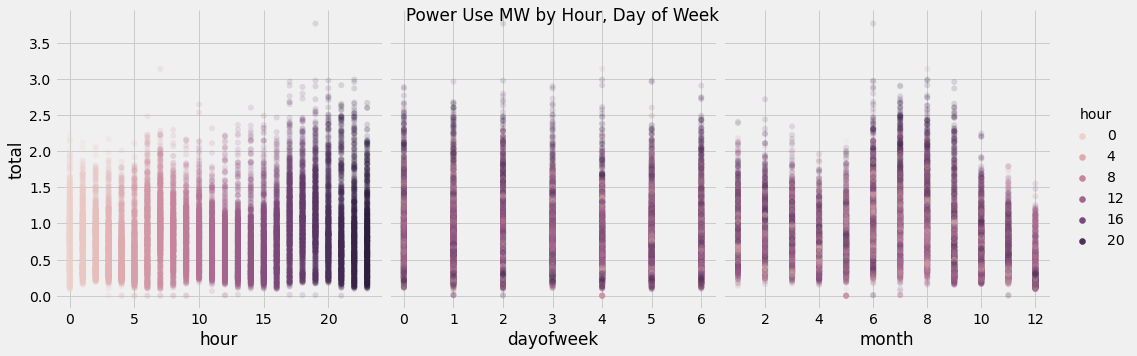

In [38]:

sns.pairplot(home_a.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek', 'month'],
             y_vars='total',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week')
plt.show()


### Forecasting using Prophet


In [40]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [41]:
#Split date
date= "2014-09-18"
X_train = home_a.loc[home_a.index<= date].copy()
X_test = home_a.loc[home_a.index> date].copy()

<AxesSubplot:xlabel='Date & Time'>

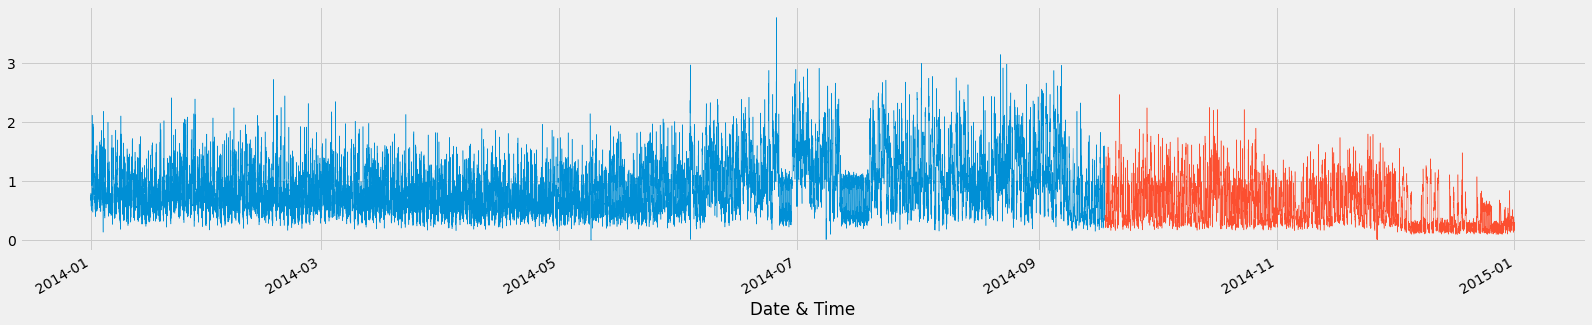

In [43]:
X_train['total'].plot(lw=0.5, figsize=(25,5))
X_test['total'].plot(lw=0.5)

In [106]:
# # Plot train and test so you can see where we have split
# X_train \
#     .rename(columns={'total': 'TRAIN SET'}) \
#     .merge(X_test.rename(columns={'total': 'TEST SET'}),
#           how='outer') \
#     .plot(figsize=(15,5), title='Train/test split', style='.',alpha= 0.5)
# plt.show()

In [44]:
X_train['ds']= X_train.index
X_test['ds'] = X_test.index

X_train = X_train[['ds','total']]
X_test = X_test[['ds','total']]

In [45]:
# Format data for prophet model using ds and y
X_train.reset_index() \
    .rename(columns={
                     'total':'y'}).head()

,Date & Time,ds,y
0,2014-01-01 00:00:00,2014-01-01 00:00:00,0.795101
1,2014-01-01 00:30:00,2014-01-01 00:30:00,0.716727
2,2014-01-01 01:00:00,2014-01-01 01:00:00,0.667612
3,2014-01-01 01:30:00,2014-01-01 01:30:00,0.767058
4,2014-01-01 02:00:00,2014-01-01 02:00:00,0.568542


In [46]:
X_train =X_train.reset_index()
X_train= X_train[['ds','total']]
X_train =X_train.rename(columns={"total":"y"})


In [110]:
X_train

,ds,y
0,2014-01-01 00:00:00,0.795101
1,2014-01-01 00:30:00,0.716727
2,2014-01-01 01:00:00,0.667612
3,2014-01-01 01:30:00,0.767058
4,2014-01-01 02:00:00,0.568542
...,...,...
12474,2014-09-17 22:00:00,1.259534
12475,2014-09-17 22:30:00,0.561248
12476,2014-09-17 23:00:00,0.329142
12477,2014-09-17 23:30:00,0.340821


In [47]:
model= Prophet(interval_width=0.95)
model.fit(X_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -118.185


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       21364.9    0.00237516       114.066      0.3992      0.9678      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       21367.2   8.41628e-05        52.545      0.6845      0.6845      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       21367.6   5.62759e-05       76.4444   3.503e-07       0.001      333  LS failed, Hessian reset 
     239       21367.7   0.000224119       149.748   4.299e-06       0.001      388  LS failed, Hessian reset 
     299       21367.9   0.000703793       123.143      0.1617      0.5807      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314         21368   5.29458e-05       87.8228   5.675e-07       0.001      531  LS failed, Hessian reset 
     399       21368.2   0.000295648 

In [48]:
X_test = X_test.reset_index().rename(columns={'total':'y'})

X_test=X_test[['ds','y']]

In [49]:
prediction= model.predict(X_test)

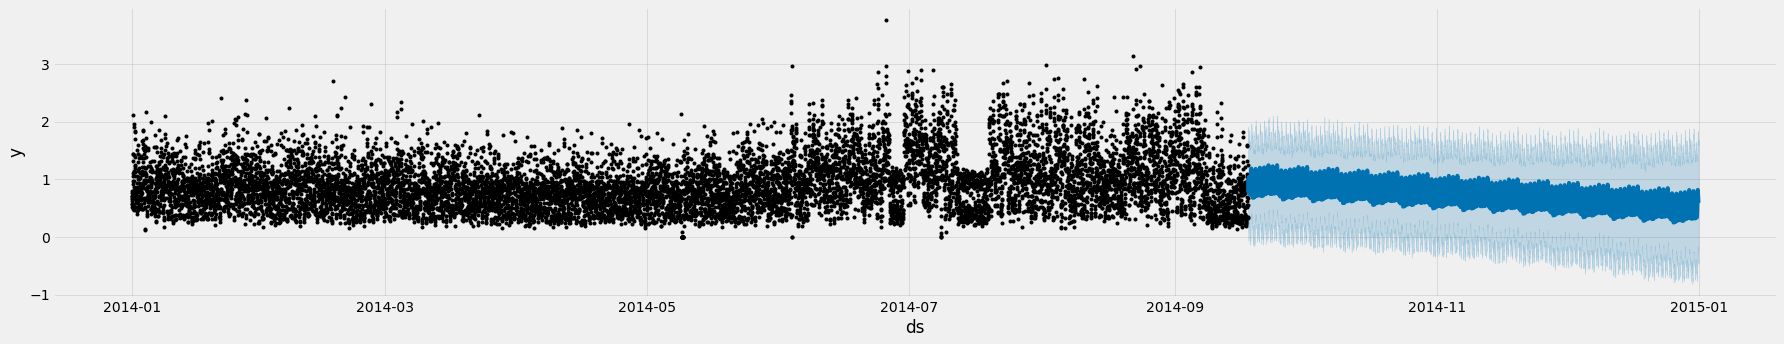

In [50]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(25)
fig = model.plot(prediction,
                 ax=ax)
plt.show()

### Using XGBoost for Time Series data

In [225]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [54]:
split_date = "2014-09-18"
home_train = home_a.loc[home_a.index <=split_date].copy()
home_test = home_a.loc[home_a.index >split_date].copy()

In [238]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    cols= df.columns
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night'] = np.where((df['hour']>=18)| (df['hour']<6),1,0)
    df['lag_hour'] = df['total'].shift(periods=2)
    df['lag_day'] = df['total'].shift(periods=48)
    df['lag_week'] = df['total'].shift(periods=336)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth', 'night', 'lag_hour','lag_day','lag_week']]
    if label:
        y = df[label]
        return X, y
    return X, cols


In [239]:
X_train, y_train = create_features(home_train, label="total")
X_test, y_test = create_features(home_test, label="total")

In [240]:
X,y = create_features(home_a, label='total')

In [241]:
reg = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


In [242]:
xgb_grid = GridSearchCV(reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [243]:
X=X.reset_index()
X.drop("Date & Time", axis=1,inplace=True)

In [244]:
X=X.values

In [245]:
tscv = TimeSeriesSplit(n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000)


In [246]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

In [247]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(xgb_grid, X, y, cv=tscv)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[15:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.[15:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.

[15:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent"

In [251]:
xgb_grid.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [252]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgb_grid.fit(
        X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)
    


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[16:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to

In [254]:
xgb_grid.n_splits_

2

In [112]:
xgb_grid.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[17:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [253]:
home_test['prediction'] = xgb_grid.predict(X_test)

ValueError: Length of values (1000) does not match length of index (5045)

In [ ]:
home_all= pd.concat([home_train, home_test], sort=False)

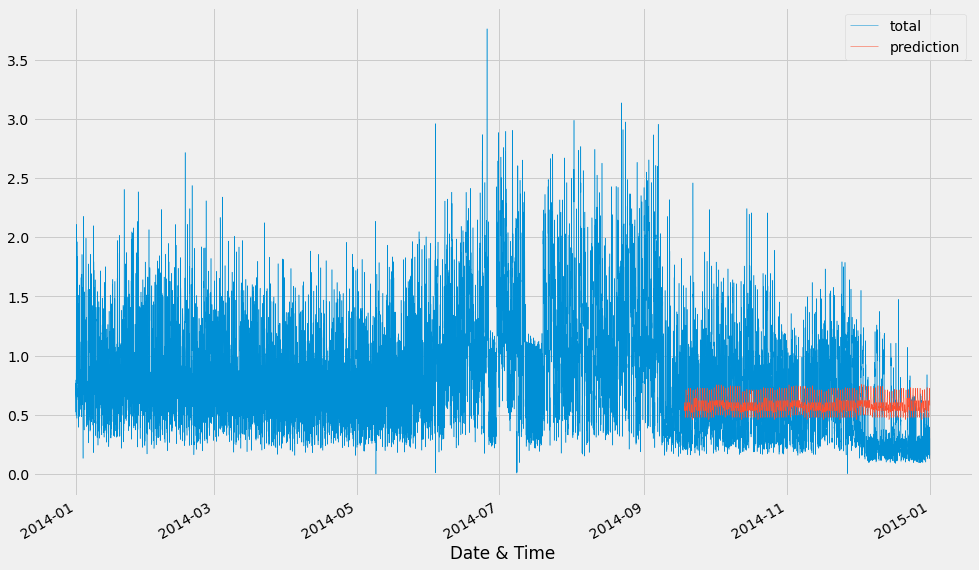

In [ ]:
_=home_all[['total','prediction']].plot(figsize=(15,10), lw=0.5)

### Using LSTMs 